##### 사용된 모델
- CNN, ResNet50V2(전이학습), EfficientNetB5, VGG16

##### 검색해볼것
- generator


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv2
import os

import PIL
import matplotlib.image as image
import seaborn as sns
import pickle 

import tensorflow as tf
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
import random
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from keras.utils.np_utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [2]:
img = cv2.imread("./tire_data/testing_data/cracked/Cracked-1.jpg")
img.shape

(748, 748, 3)

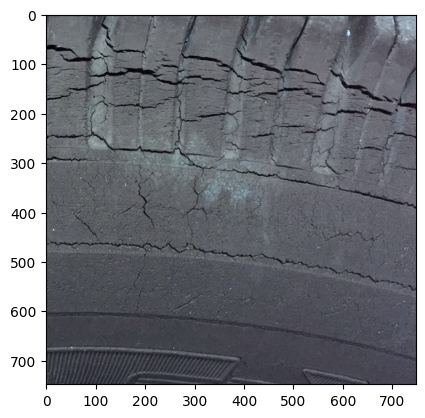

In [3]:
plt.imshow(img)

In [4]:
train_dir = "./tire_data/training_data"
test_dir = "./tire_data/testing_data"

##### Image Augmentation with Image Generator

In [5]:
#processing the dataset
train_gen_without_aug = ImageDataGenerator(rescale= 1/255.)                                                       

train_gen_with_aug = ImageDataGenerator(rescale= 1/255.,                                                        
                               rotation_range=0.2,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range = 0.2, 
                               horizontal_flip=True,
                                )

test_gen = ImageDataGenerator(rescale= 1/255.)

In [6]:
train_data = train_gen_with_aug.flow_from_directory(train_dir,
                                            target_size = (224,224),
                                            class_mode = "categorical",
                                            batch_size = 32
                                            )
test_data = test_gen.flow_from_directory(test_dir,
                                          target_size = (224,224),
                                          class_mode = "categorical",
                                          batch_size = 32
                                          )

Found 703 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


In [7]:
label_name = list(train_data.class_indices.keys())
label_name

['cracked', 'normal']

In [8]:
image,label = train_data.next()

print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 2)


Metal device set to: Apple M1


2022-11-04 15:17:53.862042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-04 15:17:53.862190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


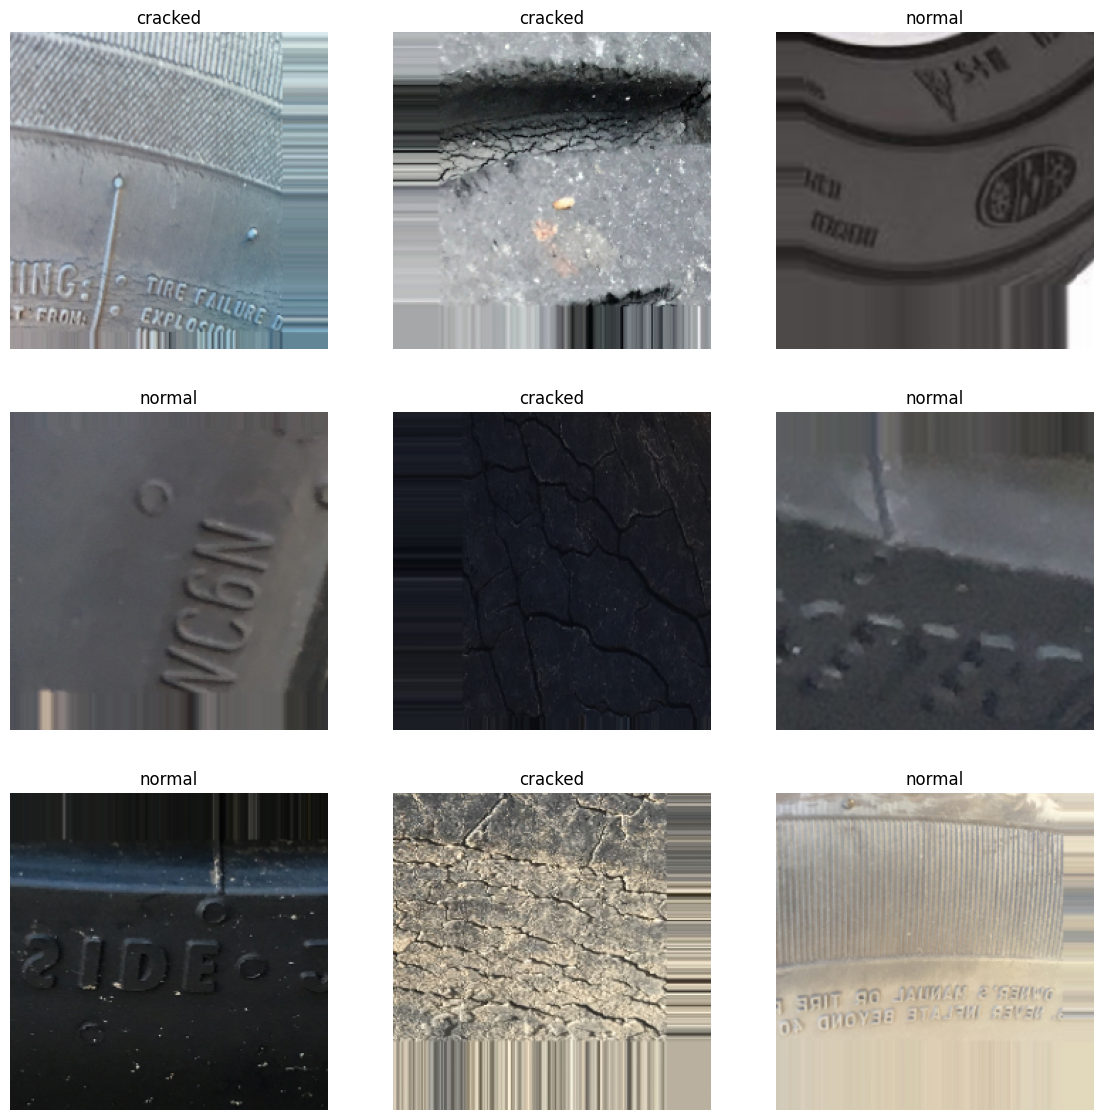

In [9]:
plt.figure(figsize=(14,14))

for i in range(9):
    image,label = train_data.next()

    plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    plt.title(label_name[tf.argmax(label[i])])
    plt.axis("off")

##### Building a CNN model

In [10]:
model = tf.keras.Sequential([
                             layers.Conv2D(filters= 32, kernel_size= 2, activation="relu", input_shape=(224,224,3)),                             
                             layers.Conv2D(filters= 16, kernel_size= 2, activation="relu"),
                             layers.Dropout(0.2),
                             layers.MaxPooling2D(pool_size= 2),
                             
                             layers.Conv2D(filters= 16, kernel_size = 2, activation= "relu"),                             
                             layers.Conv2D(filters= 16, kernel_size= 2, activation= "relu"),  
                             layers.Dropout(0.2),
                             layers.MaxPooling2D(pool_size= 2),

                             layers.Flatten(),

                             layers.Dense(1024, activation= "relu"),
                             layers.Dropout(0.2),
                             layers.Dense(1024, activation = "relu"),
                             layers.Dropout(0.2),
                             layers.Dense(1024, activation= "relu"),


                             layers.Dense(2, activation="softmax")
                            
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 16)      2064      
                                                                 
 dropout (Dropout)           (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 110, 110, 16)      1040      
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      1040      
                                                        

In [14]:
# compiling the model
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [15]:
# fitting the data to the model
model.fit(train_data,
          epochs = 10,
          steps_per_epoch = len(train_data),
          validation_data = test_data,
          validation_steps = len(test_data)
          )

Epoch 1/10


2022-11-04 15:19:02.415419: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-04 15:19:02.745400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 1.2316 - accuracy: 0.5491

2022-11-04 15:19:21.302892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 28s 1s/step - loss: 1.2316 - accuracy: 0.5491 - val_loss: 0.8537 - val_accuracy: 0.4800
Epoch 2/10
22/22 [==============================] - 23s 1s/step - loss: 0.6550 - accuracy: 0.6046 - val_loss: 0.8705 - val_accuracy: 0.4738
Epoch 3/10
22/22 [==============================] - 23s 1s/step - loss: 0.6421 - accuracy: 0.6302 - val_loss: 0.6555 - val_accuracy: 0.6154
Epoch 4/10
22/22 [==============================] - 23s 1s/step - loss: 0.6427 - accuracy: 0.6259 - val_loss: 0.6440 - val_accuracy: 0.5846
Epoch 5/10
22/22 [==============================] - 23s 1s/step - loss: 0.6438 - accuracy: 0.6415 - val_loss: 0.6196 - val_accuracy: 0.5969
Epoch 6/10
22/22 [==============================] - 23s 1s/step - loss: 0.6316 - accuracy: 0.6430 - val_loss: 0.5997 - val_accuracy: 0.6369
Epoch 7/10
22/22 [==============================] - 23s 1s/step - loss: 0.6234 - accuracy: 0.6472 - val_loss: 0.6658 - val_accuracy: 0.5631
Epoch 8/10
22/22 [=============

##### Model Evaluation

In [16]:
model.evaluate(train_data)

22/22 [==============================] - 14s 638ms/step - loss: 0.5760 - accuracy: 0.7070


[0.5759772062301636, 0.7069700956344604]

In [17]:
model.evaluate(test_data)

11/11 [==============================] - 8s 751ms/step - loss: 0.5740 - accuracy: 0.6400


[0.5740334987640381, 0.6399999856948853]

In [18]:
# resnet model using transfer learning
# 전이학습

resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50V2(include_top= False,
                                                   input_shape=(224,224, 3),
                                                   pooling='avg',
                                                   weights='imagenet')

# resnet_model.trainable = False

94668760/94668760 [==============================] - 8s 0us/step


In [19]:
# Tuning the model

# resnet_base.trainble = True

for layer in pretrained_model.layers:
    layer.trainable=False


resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))

resnet_model.compile(
     loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

resnet_model.fit(
    train_data,
    epochs = 10,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data)
)

Epoch 1/10


2022-11-04 15:25:55.478845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.8606

2022-11-04 15:26:13.877300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 29s 1s/step - loss: 0.3365 - accuracy: 0.8606 - val_loss: 0.6168 - val_accuracy: 0.7385
Epoch 2/10
22/22 [==============================] - 24s 1s/step - loss: 0.1851 - accuracy: 0.9388 - val_loss: 0.7823 - val_accuracy: 0.7200
Epoch 3/10
22/22 [==============================] - 24s 1s/step - loss: 0.1797 - accuracy: 0.9346 - val_loss: 0.7067 - val_accuracy: 0.7108
Epoch 4/10
22/22 [==============================] - 24s 1s/step - loss: 0.1194 - accuracy: 0.9474 - val_loss: 0.7221 - val_accuracy: 0.7477
Epoch 5/10
22/22 [==============================] - 24s 1s/step - loss: 0.0983 - accuracy: 0.9659 - val_loss: 0.4883 - val_accuracy: 0.7969
Epoch 6/10
22/22 [==============================] - 24s 1s/step - loss: 0.0895 - accuracy: 0.9644 - val_loss: 0.9582 - val_accuracy: 0.7292
Epoch 7/10
22/22 [==============================] - 24s 1s/step - loss: 0.0823 - accuracy: 0.9644 - val_loss: 0.5814 - val_accuracy: 0.7754
Epoch 8/10
22/22 [=============

In [20]:
resnet_model.evaluate(train_data)

22/22 [==============================] - 15s 675ms/step - loss: 0.0321 - accuracy: 0.9900


[0.03211114928126335, 0.9900426864624023]

In [21]:
resnet_model_evaluation = resnet_model.evaluate(test_data)

11/11 [==============================] - 9s 766ms/step - loss: 0.8420 - accuracy: 0.7569


In [22]:
print(f"Resnet Model Accuracy: {resnet_model_evaluation[1] * 100: 0.2f} %")

Resnet Model Accuracy:  75.69 %


In [23]:
# processing data for efficientnet model

eff_train = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                image_size = (224,224),
                                                                label_mode = "categorical",
                                                                batch_size = 32                                                            
                                                                )

eff_test = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size = (224,224),
                                                               label_mode = "categorical",
                                                               batch_size = 32
                                                               )

Found 703 files belonging to 2 classes.
Found 325 files belonging to 2 classes.


In [24]:
for image,label in eff_test.take(1):
    print(image.shape)
    print(label.shape)
    break

(32, 224, 224, 3)
(32, 2)


In [25]:
# building a model on efficientnet
effnet_base = tf.keras.applications.EfficientNetB5(include_top= False)

effnet_base.trainable = False

115263384/115263384 [==============================] - 9s 0us/step


In [26]:
# building the resnet model
import tensorflow as tf
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(224,224,3))

x = effnet_base(inputs)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(2, activation = "softmax")(x)

effnet_model = tf.keras.Model(inputs,outputs)

In [27]:
# compiling the model

effnet_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [28]:
# fitting data to the model

effnet_model.fit(
    eff_train,
    epochs = 5,
    steps_per_epoch = len(eff_train),
    validation_data = eff_test,
    validation_steps = len(eff_test)
)

Epoch 1/5


2022-11-04 15:31:33.020565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.4369 - accuracy: 0.8265

2022-11-04 15:31:58.814140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 45s 2s/step - loss: 0.4369 - accuracy: 0.8265 - val_loss: 0.5391 - val_accuracy: 0.7015
Epoch 2/5
22/22 [==============================] - 27s 1s/step - loss: 0.2605 - accuracy: 0.9118 - val_loss: 0.5524 - val_accuracy: 0.6954
Epoch 3/5
22/22 [==============================] - 27s 1s/step - loss: 0.2169 - accuracy: 0.9275 - val_loss: 0.4924 - val_accuracy: 0.7415
Epoch 4/5
22/22 [==============================] - 28s 1s/step - loss: 0.1934 - accuracy: 0.9317 - val_loss: 0.6195 - val_accuracy: 0.6923
Epoch 5/5
22/22 [==============================] - 27s 1s/step - loss: 0.1694 - accuracy: 0.9431 - val_loss: 0.5166 - val_accuracy: 0.7323


In [29]:
# Tuning the model

effnet_base.trainble = True

for layer in effnet_base.layers[:-3]:
    effnet_base.trainable = False

effnet_model.compile(
     loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

effnet_model.fit(
    eff_train,
    epochs = 10,
    steps_per_epoch = len(eff_train),
    validation_data = eff_test,
    validation_steps = len(eff_test)
)

Epoch 1/10


2022-11-04 15:34:13.694912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.9374

2022-11-04 15:34:41.290039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 50s 2s/step - loss: 0.1665 - accuracy: 0.9374 - val_loss: 0.5055 - val_accuracy: 0.7415
Epoch 2/10
22/22 [==============================] - 29s 1s/step - loss: 0.1442 - accuracy: 0.9531 - val_loss: 0.5353 - val_accuracy: 0.7292
Epoch 3/10
22/22 [==============================] - 28s 1s/step - loss: 0.1293 - accuracy: 0.9531 - val_loss: 0.5390 - val_accuracy: 0.7323
Epoch 4/10
22/22 [==============================] - 27s 1s/step - loss: 0.1293 - accuracy: 0.9545 - val_loss: 0.4997 - val_accuracy: 0.7477
Epoch 5/10
22/22 [==============================] - 27s 1s/step - loss: 0.1187 - accuracy: 0.9630 - val_loss: 0.5648 - val_accuracy: 0.7231
Epoch 6/10
22/22 [==============================] - 28s 1s/step - loss: 0.0981 - accuracy: 0.9730 - val_loss: 0.5367 - val_accuracy: 0.7354
Epoch 7/10
22/22 [==============================] - 27s 1s/step - loss: 0.1013 - accuracy: 0.9687 - val_loss: 0.5658 - val_accuracy: 0.7169
Epoch 8/10
22/22 [=============

In [30]:
effnet_model.evaluate(eff_train)

22/22 [==============================] - 22s 949ms/step - loss: 0.0584 - accuracy: 0.9915


[0.05837429687380791, 0.991465151309967]

In [31]:
effnet_evaluation = effnet_model.evaluate(eff_test)

11/11 [==============================] - 10s 670ms/step - loss: 0.5303 - accuracy: 0.7415


In [32]:
print(f"EfficientNet Model Accuarcy: {effnet_evaluation[1] * 100 :0.2f} %")

EfficientNet Model Accuarcy: 74.15 %


In [33]:
test_label = list(test_data.class_indices.keys())

test_label

['cracked', 'normal']

2022-11-04 15:39:47.162360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 23ms/step


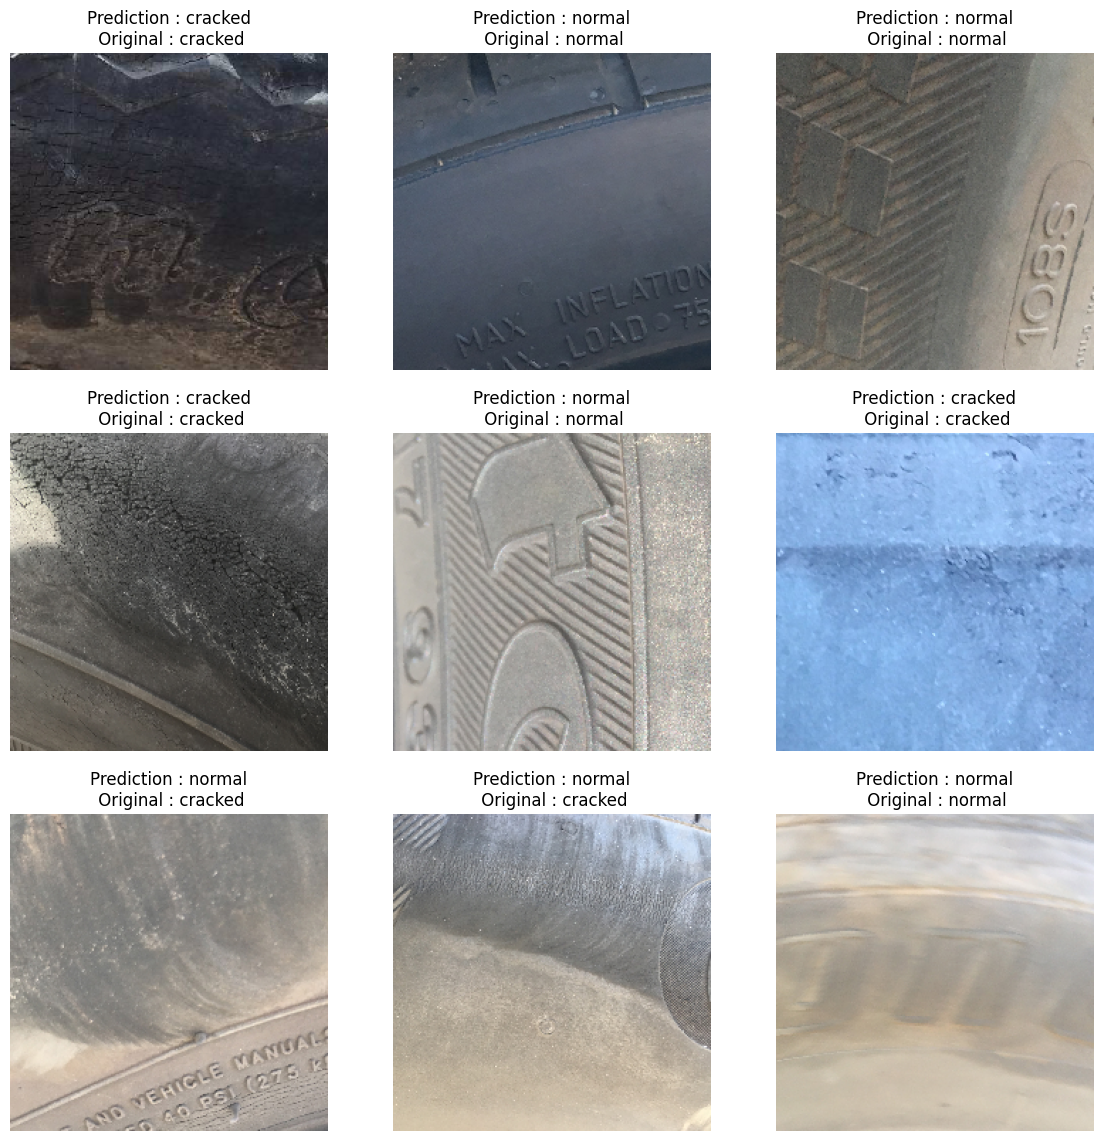

In [34]:
# Resnet model prediction and visualizing

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(14,14))

for i in range(9):
    image,label = test_data.next()
    resnet_pred = resnet_model.predict(image)
    plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    plt.title(f"Prediction : {test_label[tf.argmax(resnet_pred[i])]}\n Original : {test_label[tf.argmax(label[i])]}")
    plt.axis("off")

In [35]:
eff_label = eff_test.class_names
eff_label

['cracked', 'normal']

2022-11-04 15:40:29.288949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 7s 7s/step


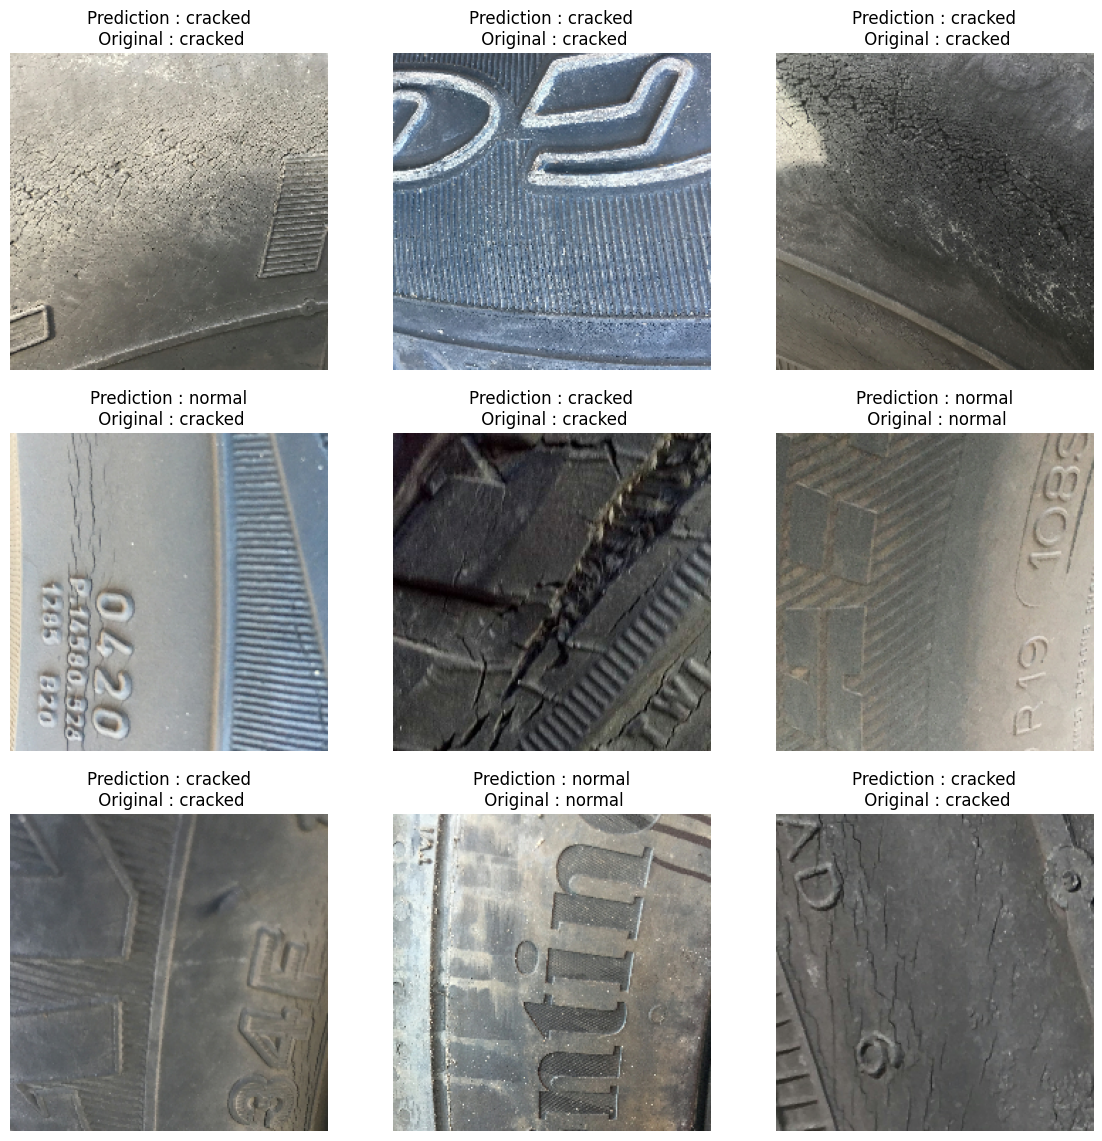

In [36]:
# Efficientnet model prediction and visualizing

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(14,14))

for image, label in eff_test.take(1):
    
    eff_pred = effnet_model.predict(image)
    for i in range(9):   
               
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(f"Prediction : {eff_label[tf.argmax(eff_pred[i])]}\n Original : {eff_label[tf.argmax(label[i])]}")
        plt.axis("off")

## Another Model Build

In [37]:
MAIN_PATH = "./tire_data/training_data"
TEST_PATH = "./tire_data/testing_data"
CLASSES = os.listdir(MAIN_PATH)
NUM_CLASSES = len(CLASSES)
NUM_TEST_IMAGES = len(os.listdir(os.path.join(TEST_PATH,"cracked")))+len(os.listdir(os.path.join(TEST_PATH,"normal")))
HEIGHT,WIDTH = 32,32
BATCH_SIZE = 32
SPLIT = 0.2

In [38]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=SPLIT)
'''
    width_shift_range=0.2,
    height_shift_range=0.2,
    '''
train_ds = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "training",
    class_mode = "categorical",
    shuffle = True
)

val_ds = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "validation",
    class_mode = "categorical",
    shuffle = True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size = (HEIGHT,WIDTH),
    shuffle = False
)

Found 563 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


##### Model Build

In [39]:
def create_model():
    vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=[HEIGHT,WIDTH, 3])
            
    x = vgg16.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3) (x)
    x = tf.keras.layers.Dense(128) (x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2) (x)
    x = tf.keras.layers.GaussianDropout(0.4) (x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES,activation="sigmoid", dtype='float32')(x)
        
    model = tf.keras.Model(vgg16.input, outputs)
    return model

model = create_model()
model.summary()

58889256/58889256 [==============================] - 5s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                            

In [40]:
def compile_model(model, lr=0.0001):
    
    optimizer = tf.keras.optimizers.RMSprop(lr=1e-4)
    
    loss = tf.keras.losses.BinaryCrossentropy()
        
    metrics = [
       tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [41]:
def create_callbacks():
    
    cpk_path = './best_model.h5'
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor='val_binary_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_binary_accuracy',
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_binary_accuracy',
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

In [42]:
EPOCHS= 60
VERBOSE =1

tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    
    model = create_model()
    model = compile_model(model, lr=0.0001)
   
    callbacks = create_callbacks()
    
    history = model.fit(train_ds, 
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = val_ds,
                        verbose=VERBOSE)

Epoch 1/60


2022-11-04 15:47:35.659040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 0.7268 - binary_accuracy: 0.5391

2022-11-04 15:47:50.132944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_binary_accuracy improved from -inf to 0.56786, saving model to ./best_model.h5
18/18 [==============================] - 19s 761ms/step - loss: 0.7268 - binary_accuracy: 0.5391 - val_loss: 0.6944 - val_binary_accuracy: 0.5679 - lr: 1.0000e-04
Epoch 2/60
18/18 [==============================] - ETA: 0s - loss: 0.6582 - binary_accuracy: 0.6359
Epoch 2: val_binary_accuracy did not improve from 0.56786
18/18 [==============================] - 11s 640ms/step - loss: 0.6582 - binary_accuracy: 0.6359 - val_loss: 0.7832 - val_binary_accuracy: 0.5429 - lr: 1.0000e-04
Epoch 3/60
18/18 [==============================] - ETA: 0s - loss: 0.6363 - binary_accuracy: 0.6776
Epoch 3: val_binary_accuracy did not improve from 0.56786
18/18 [==============================] - 11s 629ms/step - loss: 0.6363 - binary_accuracy: 0.6776 - val_loss: 0.8616 - val_binary_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 4/60
18/18 [==============================] - ETA: 0s - loss: 0.6154 - binary_accuracy: 0.7016

##### Metrics Visualization

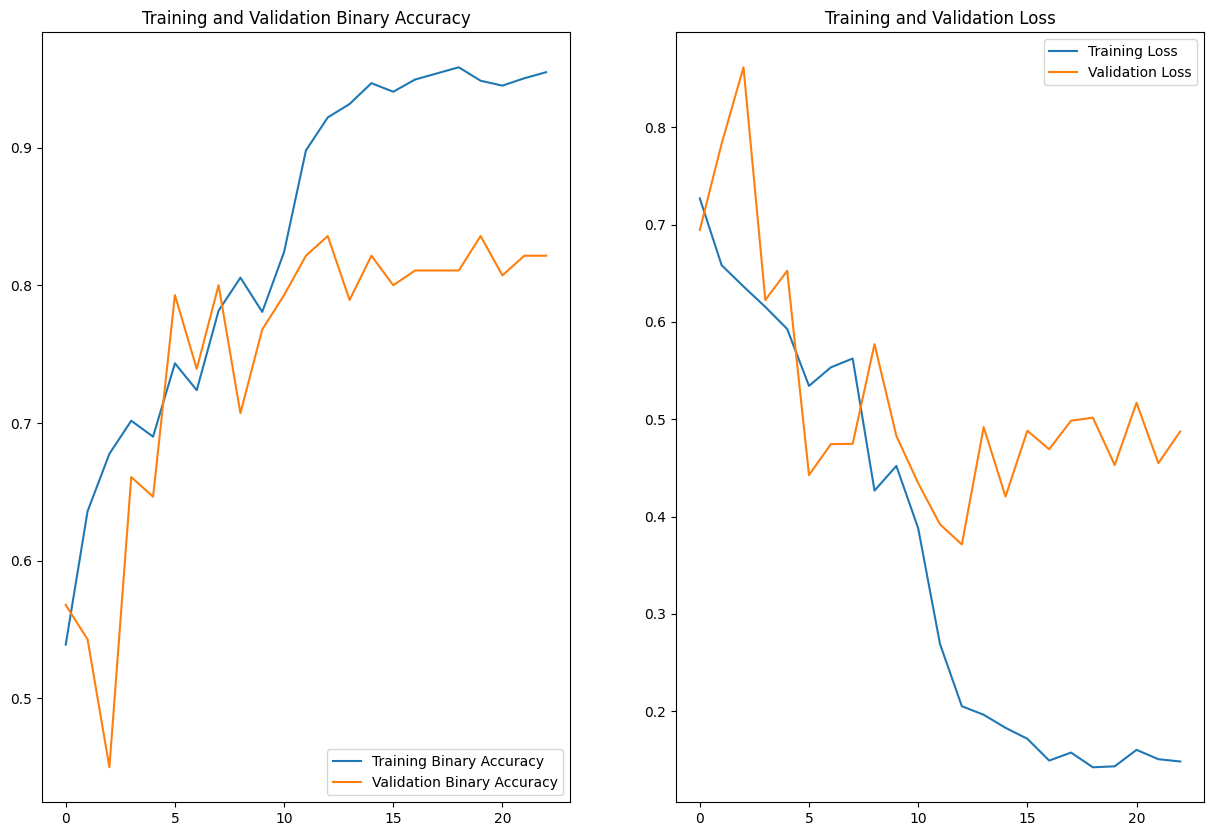

In [43]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Binary Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Binary Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Binary Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Test eval

In [44]:
model.evaluate(test_ds)

11/11 [==============================] - 9s 859ms/step - loss: 0.6776 - binary_accuracy: 0.7415


[0.6776062250137329, 0.7415384650230408]

- 모델 선택 참고 논문
> https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO202011161035249&dbt=NART

- DataSet
> https://www.kaggle.com/datasets/jehanbhathena/tire-texture-image-recognition/code

- 참고 모델 building
> https://www.kaggle.com/code/harshwalia/tire-texture-image-recognition
> 



- 나중에 해볼 것 ( 교통표지판 )
> https://www.kaggle.com/datasets/shanmukh05/traffic-sign-cropped
> https://www.kaggle.com/code/shanmukh05/traffic-sign-recognition/notebook